**Nova Iguaçu - RJ**

In [39]:
# Importando módulos internos
import geocov19_functions_results as fresults

# Importando módulos externos
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statistics import mean
from wordcloud import WordCloud

In [40]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)
db = client.SpedDB
collection = db.tweets_brasil

In [41]:
city = 'Nova Iguaçu'
df = pd.DataFrame.from_records(collection.find({'lang': 'pt', 'city':city, 'score': {'$ne':None}, '$or':[{'geo_source':'place'}, {'geo_source':'user_location'}]}, {'state':1,'city':1,'lang':1,'geo_source':1,'score':1,'created_at':1,'text':1,'_id': 0}).sort('created_at'))

In [42]:
len(df)

15832

In [43]:
df.head()

,created_at,geo_source,state,city,text,score,lang
0,2020-02-02 12:12:09,user_location,Rio de Janeiro,Nova Iguaçu,RT @minsaude: ⚠Não compartilhe mensagem sobre ...,-0.6108,pt
1,2020-02-02 12:38:58,user_location,Rio de Janeiro,Nova Iguaçu,"que os chineses tomem bastante no cu, tomara q...",-0.8481,pt
2,2020-02-02 12:42:29,user_location,Rio de Janeiro,Nova Iguaçu,gente? https://t.co/tFgwfoyC9t,0.0000,pt
3,2020-02-02 13:27:38,user_location,Rio de Janeiro,Nova Iguaçu,RT @MidiaNINJA: O coronavirus é um ótimo exemp...,0.0000,pt
4,2020-02-02 16:41:48,user_location,Rio de Janeiro,Nova Iguaçu,E se na verdade o coronavirus for uma arma bio...,0.3589,pt


Média total de sentimentos - Vader

In [44]:
df['score'].describe()

count    15832.000000
mean        -0.013217
std          0.429787
min         -0.997000
25%         -0.318200
50%          0.000000
75%          0.296000
max          0.996800
Name: score, dtype: float64

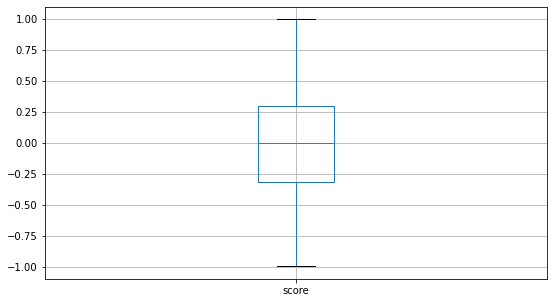

In [45]:
boxplot = df.boxplot(column=['score'], grid=True, figsize=(9, 5))

Análises por período

In [46]:
# Carregando arquivo CSV contendo casos de covid 19 do Brasil
file = '/home/mario/Documentos/LCDIA/Analytics/Datasets/caso_full.csv'
df_cases_brasil = pd.read_csv(file, usecols=['city', 'state', 'date', 'new_confirmed', 'new_deaths','last_available_confirmed','last_available_deaths','last_available_confirmed_per_100k_inhabitants','last_available_death_rate'])

In [124]:
# Selecionando casos da cidade analisada
df_cases_city = df_cases_brasil.query('city == "'+city+'"')
df_cases_city = df_cases_city.reset_index()
df_cases_city = df_cases_city.drop(columns=['index'])
df_cases_city.head()

,city,date,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_death_rate,last_available_deaths,state,new_confirmed,new_deaths
0,Nova Iguaçu,2020-03-28,1,0.12146,0.0,0,RJ,1,0
1,Nova Iguaçu,2020-03-29,3,0.36439,0.0,0,RJ,2,0
2,Nova Iguaçu,2020-03-30,7,0.85023,0.0,0,RJ,4,0
3,Nova Iguaçu,2020-03-31,7,0.85023,0.0,0,RJ,0,0
4,Nova Iguaçu,2020-04-01,7,0.85023,0.0,0,RJ,0,0


In [125]:
# Data do início das medidas restritivas
restriction_date = '2020-03-17'
print(restriction_date)

2020-03-17


In [126]:
# Data do primeiro caso 
first_case_date = df_cases_city.loc[0, 'date']
print(first_case_date)

2020-03-28


In [127]:
# Data da primeira morte
result = df_cases_city.query('last_available_deaths != "0"')
first_death_date = df_cases_city.loc[min(result.index), 'date']
print(first_death_date)

2020-04-04


Média de sentimentos por dia

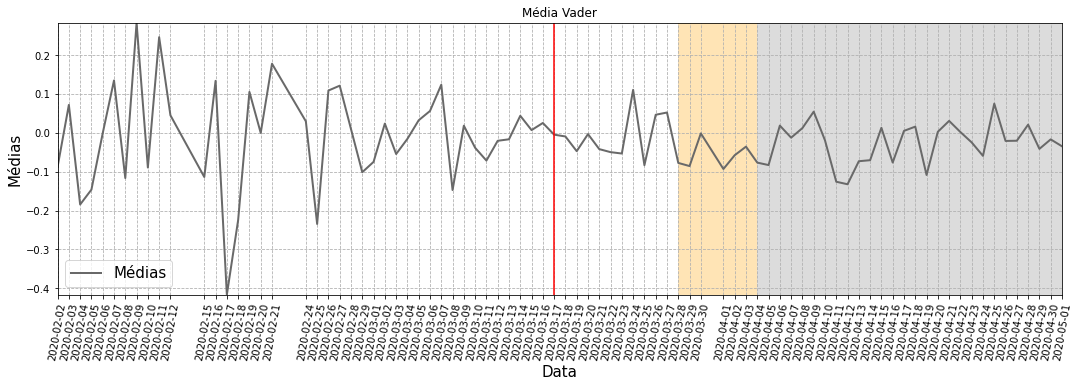

In [128]:
df_scores_city = fresults.building_dates_df(df, 'score')

x = df_scores_city.created_at
y = df_scores_city.score_mean

color = 'dimgrey'

label = 'Médias'
xLabel = 'Data'
yLabel = 'Médias'

title = 'Média Vader'

fresults.generate_graphic_cases(x, y, label, color, xLabel, yLabel, title, restriction_date, first_case_date, first_death_date)

**Análises por Período - Geral**

In [129]:
df_periodo1 = df.query('created_at >= "2020-02-01 00:00:00" and created_at < "'+first_case_date+' 00:00:00"')
print(len(df_periodo1))

df_periodo2 = df.query('created_at >= "'+first_case_date+' 00:00:00" and created_at < "'+first_death_date+' 00:00:00"')
print(len(df_periodo2))

df_periodo3 = df.query('created_at >= "'+first_death_date+' 00:00:00" and created_at < "2020-05-02 00:00:00"')
print(len(df_periodo3))

7216
982
7634


In [130]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

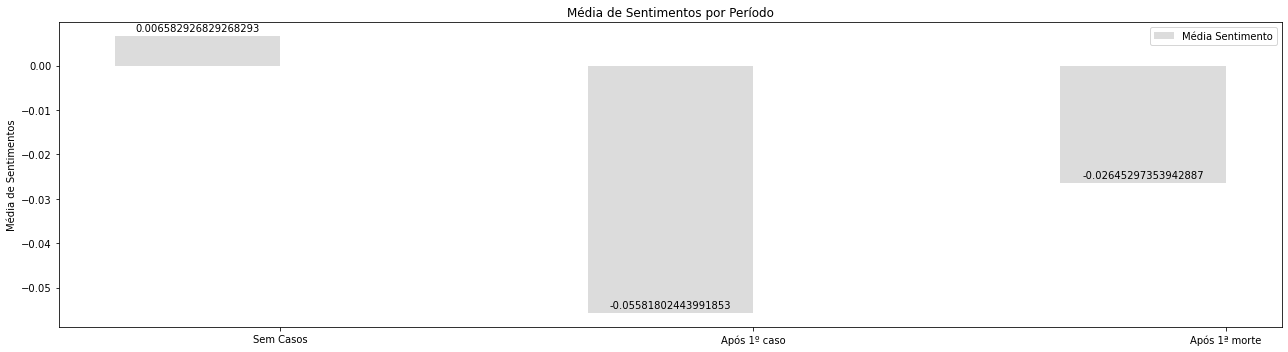

In [131]:
labels = ['Sem Casos', 'Após 1º caso', 'Após 1ª morte']
y1 = [mean(df_periodo1['score']), mean(df_periodo2['score']), mean(df_periodo3['score'])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, y1, width, label='Média Sentimento', color='gainsboro')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Média de Sentimentos')
ax.set_title('Média de Sentimentos por Período')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)

fig.tight_layout()

plt.show()

***
**Análises por Período - Detalhado**

**Tweets Negativos**

In [132]:
start = df['score'].describe()['min']
end = df['score'].describe()['25%']

print(start,end)

-0.997 -0.3182


Nuvem de palavras dos tweets mais negativos

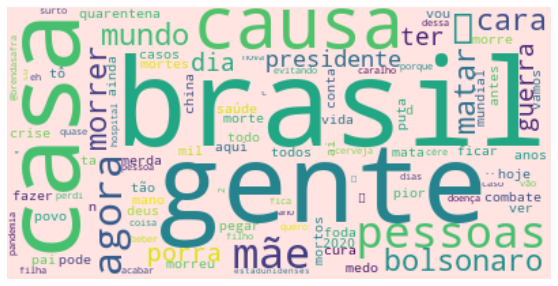

In [133]:
tokens_neg = fresults.return_tokens_from_interval(df, start, end)
fresults.generate_cloud_from_tokens(tokens_neg, 'mistyrose')

Palavras presentes nos tweets que mais influenciaram negativamente

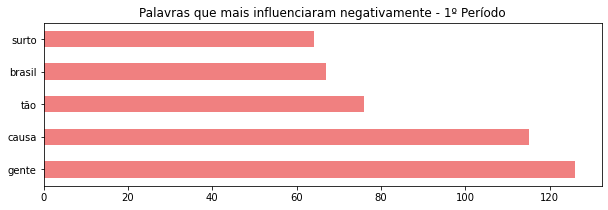

In [134]:
title = 'Palavras que mais influenciaram negativamente - 1º Período'
tokens_neg_1 = fresults.return_tokens_from_interval(df_periodo1, start, end)
fresults.generate_bar_from_tokens(tokens_neg_1, 5, 'lightcoral', 10, 3, title)

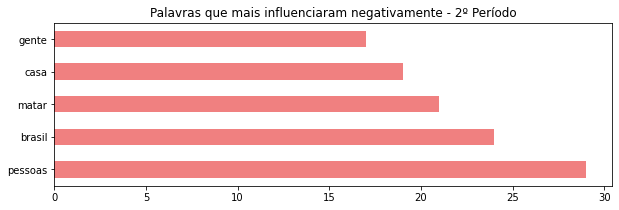

In [135]:
title = 'Palavras que mais influenciaram negativamente - 2º Período'
tokens_neg_2 = fresults.return_tokens_from_interval(df_periodo2, start, end)
fresults.generate_bar_from_tokens(tokens_neg_2, 5, 'lightcoral', 10, 3, title)

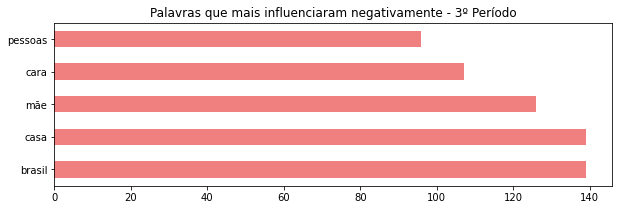

In [136]:
title = 'Palavras que mais influenciaram negativamente - 3º Período'
tokens_neg_3 = fresults.return_tokens_from_interval(df_periodo3, start, end)
fresults.generate_bar_from_tokens(tokens_neg_3, 5, 'lightcoral', 10, 3, title)

Hashtags que mais influenciaram negativamente

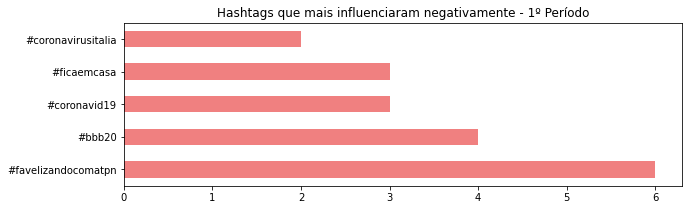

In [137]:
title = 'Hashtags que mais influenciaram negativamente - 1º Período'
fresults.generate_bar_from_filtered_tokens(tokens_neg_1, 5, '#', 'lightcoral', 10, 3, title)

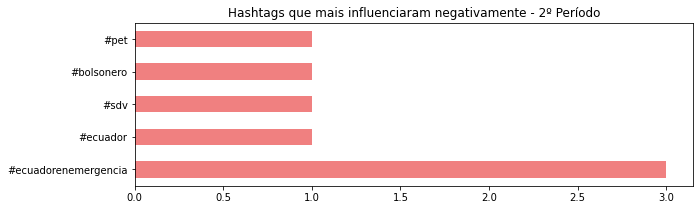

In [138]:
title = 'Hashtags que mais influenciaram negativamente - 2º Período'
fresults.generate_bar_from_filtered_tokens(tokens_neg_2, 5, '#', 'lightcoral', 10, 3, title)

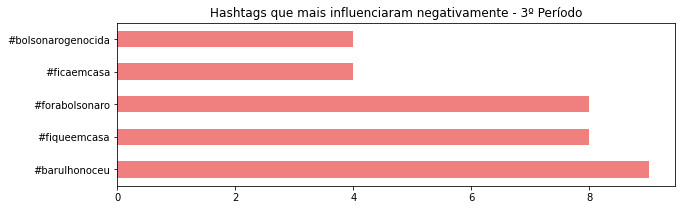

In [139]:
title = 'Hashtags que mais influenciaram negativamente - 3º Período'
fresults.generate_bar_from_filtered_tokens(tokens_neg_3, 5, '#', 'lightcoral', 10, 3, title)

**Tweets Positivos**

In [140]:
start = df['score'].describe()['75%']
end = df['score'].describe()['max']

print(start,end)

0.296 0.9968


Nuvens de palavras que influenciaram positivamente

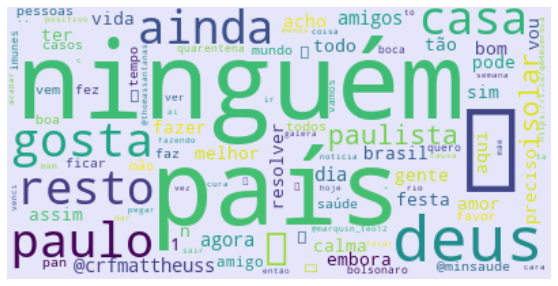

In [141]:
tokens_pos = fresults.return_tokens_from_interval(df, start, end)
fresults.generate_cloud_from_tokens(tokens_pos, 'lavender')

Palavras presentes nos tweets que mais influenciaram positivamente

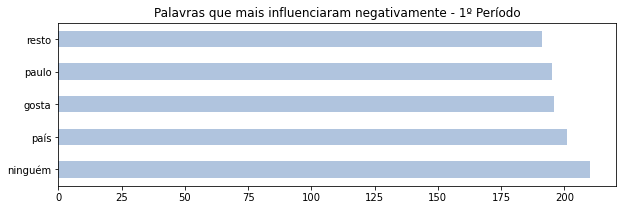

In [142]:
title = 'Palavras que mais influenciaram negativamente - 1º Período'
tokens_pos_1 = fresults.return_tokens_from_interval(df_periodo1, start, end)
fresults.generate_bar_from_tokens(tokens_pos_1, 5, 'lightsteelblue', 10, 3, title)

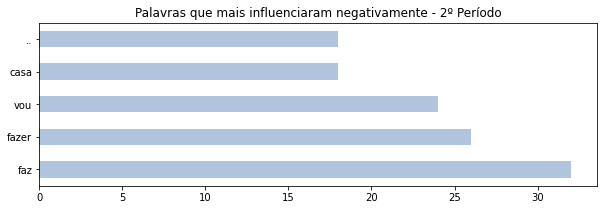

In [143]:
title = 'Palavras que mais influenciaram negativamente - 2º Período'
tokens_pos_2 = fresults.return_tokens_from_interval(df_periodo2, start, end)
fresults.generate_bar_from_tokens(tokens_pos_2, 5, 'lightsteelblue', 10, 3, title)

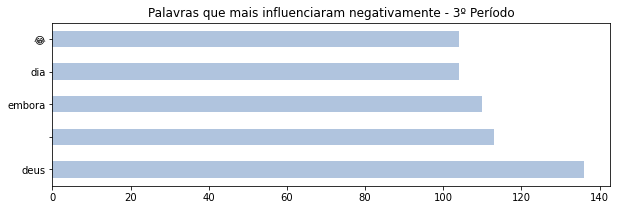

In [144]:
title = 'Palavras que mais influenciaram negativamente - 3º Período'
tokens_pos_3 = fresults.return_tokens_from_interval(df_periodo3, start, end)
fresults.generate_bar_from_tokens(tokens_pos_3, 5, 'lightsteelblue', 10, 3, title)

Hashtags que mais influenciaram positivamente

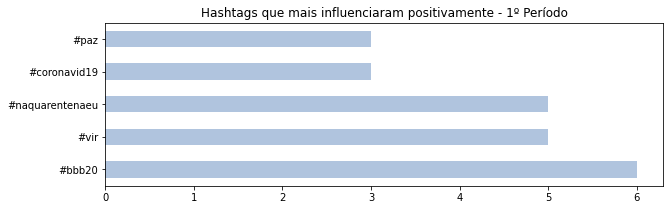

In [145]:
title = 'Hashtags que mais influenciaram positivamente - 1º Período'
fresults.generate_bar_from_filtered_tokens(tokens_pos_1, 5, '#', 'lightsteelblue', 10, 3, title)

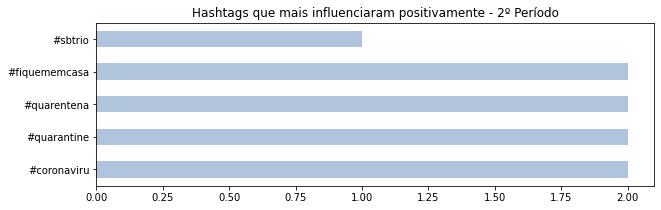

In [146]:
title = 'Hashtags que mais influenciaram positivamente - 2º Período'
fresults.generate_bar_from_filtered_tokens(tokens_pos_2, 5, '#', 'lightsteelblue', 10, 3, title)

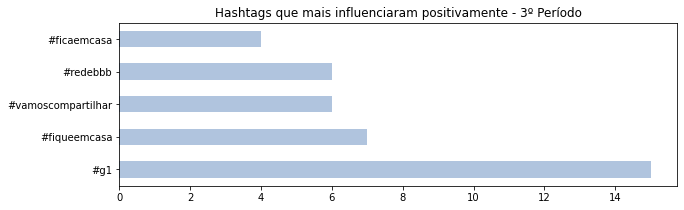

In [147]:
title = 'Hashtags que mais influenciaram positivamente - 3º Período'
fresults.generate_bar_from_filtered_tokens(tokens_pos_3, 5, '#', 'lightsteelblue', 10, 3, title)